# Reactions
In this example, we will initialize a reaction that represents the formation of water from its elements (i.e. H2 + 0.5O2 -> H2O) and calculate reaction properties. Note that in this example, we will make arbitrary transition state species and BEP relationships so the values calculated are not representative of real-world reactions.

## Topics Covered
- Read a thermdat file and convert it to a dictionary of ``Nasa`` objects
- Initialize a ``Reaction`` object manually and from strings
- Add a BEP relationship to a ``Reaction`` object
- Calculate thermodynamic and kinetic properties using the ``Reaction`` object
- Save the ``Reaction`` object as a ``JSON`` file

## Files Required
- [thermdat](thermdat) Thermdat file used to initialize ``Nasa`` species

## Initialize Species Used For Reaction
First, we need to describe our species as pMuTT objects. For this example, we will be importing the thermdat from the [combustion database by Berkeley](http://combustion.berkeley.edu/gri_mech/version30/files30/thermo30.dat). We will store the species in a dictionary for code clarity later on.

In [1]:
from pprint import pprint
from pmutt.io.thermdat import read_thermdat
from pmutt import pmutt_list_to_dict

# The output will be a list
species_list = read_thermdat(filename='thermdat')

# This function converts the list to a dict for easier usage downstream
species_dict = pmutt_list_to_dict(pmutt_list=species_list, key='name')

# (Optional) Print the species_dict to see what's in it
pprint(species_dict)

{'H2': <pmutt.empirical.nasa.Nasa object at 0x000001C65F321C88>,
 'H2O': <pmutt.empirical.nasa.Nasa object at 0x000001C65F321D68>,
 'O2': <pmutt.empirical.nasa.Nasa object at 0x000001C6587F93C8>}


To calculate transition state properties, we will need to represent the transition state species as a pMuTT object. For this example, we will create a new ``Nasa`` object based on the H2O entry but modify the a6 parameter arbitrarily to give it a higher enthalpy.

In [2]:
from copy import deepcopy

# Make a copy so we don't edit the original H2O
H2O_TS = deepcopy(species_dict['H2O'])

# Change name to differentiate it
H2O_TS.name = 'H2O_TS'

# Increase the H/RT value
H2O_TS.a_low[5] += 50.
H2O_TS.a_high[5] += 50.

# Add it to the dictionary
species_dict['H2O_TS'] = H2O_TS

# (Optional) Print the new dictionary to see the new entry
pprint(species_dict)

{'H2': <pmutt.empirical.nasa.Nasa object at 0x000001C65F321C88>,
 'H2O': <pmutt.empirical.nasa.Nasa object at 0x000001C65F321D68>,
 'H2O_TS': <pmutt.empirical.nasa.Nasa object at 0x000001C65F350470>,
 'O2': <pmutt.empirical.nasa.Nasa object at 0x000001C6587F93C8>}


## Initialize Reaction Manually
Let us initialize the reaction manually. You will have to feed the reactants, transition states, products and their stoichiometries.

In [3]:
from pmutt.reaction import Reaction

rxn = Reaction(reactants=[species_dict['H2'], species_dict['O2']], reactants_stoich=[1., 0.5],
               products =[species_dict['H2O']], products_stoich=[1.],
               transition_state=species_dict['H2O_TS'], transition_state_stoich=[1.])
# (Optional) Converting a Reaction object to a string will give its stoichiometric formula
print('Creating Reaction object manually: {}'.format(rxn))

Creating Reaction object manually: H2+0.50O2=H2O_TS=H2O


## Initialize Reaction Using Strings
Initializing manually is cumbersome and prone to error. Instead, we can use ``.from_string()`` to initialize the reaction more easily.

In [4]:
rxn = Reaction.from_string(reaction_str='H2 + 0.5O2 = H2O_TS = H2O', species=species_dict)

# See that you get the same stoichiometry as before
print('Creating Reaction object using default string notation: {}'.format(rxn))

# You can specify the notation for the reaction!
rxn = Reaction.from_string(reaction_str='H2 ++ 0.5O2 --> H2O_TS --> H2O', 
                           species=species_dict,
                           species_delimiter='++',
                           reaction_delimiter='-->')
# When reprinting it, it will converts it to the standard notation
print('Creating Reaction object using custom string notation: {}'.format(rxn))

Creating Reaction object using default string notation: H2+0.50O2=H2O_TS=H2O
Creating Reaction object using custom string notation: H2+0.50O2=H2O_TS=H2O


## Calculate Thermodynamic Reaction Properties
With the reaction object specified, we can now calculate reaction properties. Let us calculate the standard formation enthalpy and standard entropy.

In [5]:
from pmutt import constants as c

T = 298.
dH_298 = rxn.get_delta_H(T=T, units='kJ/mol')
dS_298 = rxn.get_delta_S(T=T, units='J/mol/K')

print('Calculated using Reaction object:')
print('Delta H: {} kJ/mol'.format(dH_298))
print('Delta S: {} J/mol/K'.format(dS_298))
print('\n')
print('Expected result from NIST:')
print('Delta H: -241.826 kJ/mol')
print('Delta S: {} J/mol/K'.format(188.84-130.68-0.5*205.152))

Calculated using Reaction object:
Delta H: -241.82304908408534 kJ/mol
Delta S: -44.42136350776074 J/mol/K


Expected result from NIST:
Delta H: -241.826 kJ/mol
Delta S: -44.416 J/mol/K


A ``Reaction`` object can only calculate properties its reactants, transition state, and products can calculate. In this example, we represented our species as ``Nasa`` objects so we can only calculate change in heat capacity (ΔCp), enthalpy (ΔH), entropy (ΔS), and Gibbs energy (ΔG).

If you used ``StatMech`` objects instead of ``Nasa`` objects, you can calculate a wider variety of properties.

## Calculate Kinetic Reaction Properties
Since we added a transition state to the ``Reaction`` object, we can calculate kinetic properties such as the activation energy (Ea) and the pre-exponential factor (A). Since we arbitrarily made a transition state species, take the printed value with a grain of salt

In [6]:
# Forward direction properties (i.e. reactants to transition state)
H_TS = rxn.get_delta_H(T=T, activation=True, units='kJ/mol')
Ea = rxn.get_E_act(T=T, units='kJ/mol')
A = rxn.get_A(T=T)

# Take these values with a grain of salt since we arbitrarily 
# specified our transition state
print('Forward properties')
print('Enthalpy of activation: {:.2f} kJ/mol'.format(H_TS))
print('Activation Energy: {:.2f} kJ/mol'.format(Ea))
print('Pre-exponential factor: {:.3e} 1/s'.format(A))
print('\n')
# Reverse direction properties (i.e. products to transition state)
H_TS_rev = rxn.get_delta_H(T=T, activation=True, rev=True, units='kJ/mol')
Ea_rev = rxn.get_E_act(T=T, rev=True, units='kJ/mol')
A_rev = rxn.get_A(T=T, rev=True)

print('Reverse properties')
print('Enthalpy of activation: {:.2f} kJ/mol'.format(H_TS_rev))
print('Activation Energy: {:.2f} kJ/mol'.format(Ea_rev))
print('Pre-exponential factor: {:.3e} 1/s'.format(A_rev))

Forward properties
Enthalpy of activation: -241.82 kJ/mol
Activation Energy: -241.41 kJ/mol
Pre-exponential factor: 2.970e+10 1/s


Reverse properties
Enthalpy of activation: 241.82 kJ/mol
Activation Energy: 0.42 kJ/mol
Pre-exponential factor: 6.209e+12 1/s


## Calculating Activation Energy Using BEP Relationships
A ``BEP`` object can be used instead of a transition state species to calculate activation energies. Again, we will arbitrarily create a BEP relationship.

In [7]:
from pmutt.reaction.bep import BEP

species_dict['BEP'] = BEP(name='BEP', slope=0.2, intercept=100., descriptor='delta_H')
rxn = Reaction.from_string(reaction_str='H2 + 0.5O2 = BEP = H2O', species=species_dict)
Ea_BEP = rxn.get_E_act(T=T, units='kJ/mol')

print('BEP: {:.2f} kJ/mol'.format(Ea_BEP))


BEP: 370.04 kJ/mol


## Saving and Loading our Reaction as JSON
Similarly to pMuTT objects, ``Reaction`` objects can be saved to and read from JSON format.

In [8]:
import json
from pmutt.io.json import pmuttEncoder, json_to_pmutt

# Saving
with open('reaction.json', 'w') as f_ptr:
    json.dump(rxn, f_ptr, cls=pmuttEncoder, indent=True)
    
# Loading
with open('reaction.json', 'r') as f_ptr:
    rxn_io = json.load(f_ptr, object_hook=json_to_pmutt)

# (Optional) Print your rxn to show it was loaded correctly
dH_298_io = rxn_io.get_delta_H(T=T, units='kJ/mol')
Ea_io = rxn_io.get_E_act(T=T, units='kJ/mol')

print(rxn_io)
print('Delta H: {:.2f} kJ/mol'.format(dH_298_io))
print('Activation Energy: {:.2f} kJ/mol'.format(Ea_io))

H2+0.50O2=BEP=H2O
Delta H: -241.82 kJ/mol
Activation Energy: 370.04 kJ/mol


Here is the resulting JSON file.
```
{
 "class": "<class 'pmutt.reaction.Reaction'>",
 "reactants": [
  {
   "class": "<class 'pmutt.empirical.nasa.Nasa'>",
   "type": "nasa",
   "name": "H2",
   "phase": "G",
   "elements": {
    "H": 2
   },
   "notes": "TPIS78",
   "smiles": null,
   "model": null,
   "misc_models": [
    {
     "class": "<class 'pmutt.empirical.GasPressureAdj'>"
    }
   ],
   "a_low": [
    2.34433112,
    0.00798052075,
    -1.9478151e-05,
    2.01572094e-08,
    -7.37611761e-12,
    -917.935173,
    0.683010238
   ],
   "a_high": [
    3.3372792,
    -4.94024731e-05,
    4.99456778e-07,
    -1.79566394e-10,
    2.00255376e-14,
    -950.158922,
    -3.20502331
   ],
   "T_low": 200.0,
   "T_mid": 1000.0,
   "T_high": 3500.0,
   "cat_site": null,
   "n_sites": null
  },
  {
   "class": "<class 'pmutt.empirical.nasa.Nasa'>",
   "type": "nasa",
   "name": "O2",
   "phase": "G",
   "elements": {
    "O": 2
   },
   "notes": "TPIS89",
   "smiles": null,
   "model": null,
   "misc_models": [
    {
     "class": "<class 'pmutt.empirical.GasPressureAdj'>"
    }
   ],
   "a_low": [
    3.78245636,
    -0.00299673416,
    9.84730201e-06,
    -9.68129509e-09,
    3.24372837e-12,
    -1063.94356,
    3.65767573
   ],
   "a_high": [
    3.28253784,
    0.00148308754,
    -7.57966669e-07,
    2.09470555e-10,
    -2.16717794e-14,
    -1088.45772,
    5.45323129
   ],
   "T_low": 200.0,
   "T_mid": 1000.0,
   "T_high": 3500.0,
   "cat_site": null,
   "n_sites": null
  }
 ],
 "reactants_stoich": [
  1.0,
  0.5
 ],
 "products": [
  {
   "class": "<class 'pmutt.empirical.nasa.Nasa'>",
   "type": "nasa",
   "name": "H2O",
   "phase": "G",
   "elements": {
    "H": 2,
    "O": 1
   },
   "notes": "L 8/89",
   "smiles": null,
   "model": null,
   "misc_models": [
    {
     "class": "<class 'pmutt.empirical.GasPressureAdj'>"
    }
   ],
   "a_low": [
    4.19864056,
    -0.0020364341,
    6.52040211e-06,
    -5.48797062e-09,
    1.77197817e-12,
    -30293.7267,
    -0.849032208
   ],
   "a_high": [
    3.03399249,
    0.00217691804,
    -1.64072518e-07,
    -9.7041987e-11,
    1.68200992e-14,
    -30004.2971,
    4.9667701
   ],
   "T_low": 200.0,
   "T_mid": 1000.0,
   "T_high": 3500.0,
   "cat_site": null,
   "n_sites": null
  }
 ],
 "products_stoich": [
  1.0
 ],
 "transition_state": [
  {
   "class": "<class 'pmutt.reaction.bep.BEP'>",
   "name": "BEP",
   "slope": 0.2,
   "intercept": 100.0,
   "descriptor": "delta_H",
   "notes": null
  }
 ],
 "transition_state_stoich": [
  1.0
 ]
}
```

## Plotting Reaction Coordinate Diagrams

The ``pmutt.reaction.Reactions.plot_coordinate_diagram`` allows users to plot reaction coordinate diagrams in a semi-automated way. For this example, we will use the synthesis of NH3 on Ru. The thermdat file was taken from the [NH3 MATLAB Microkinetic Model available on Github][0].

[0]: https://github.com/VlachosGroup/NH3-Matlab-Microkinetic-Model

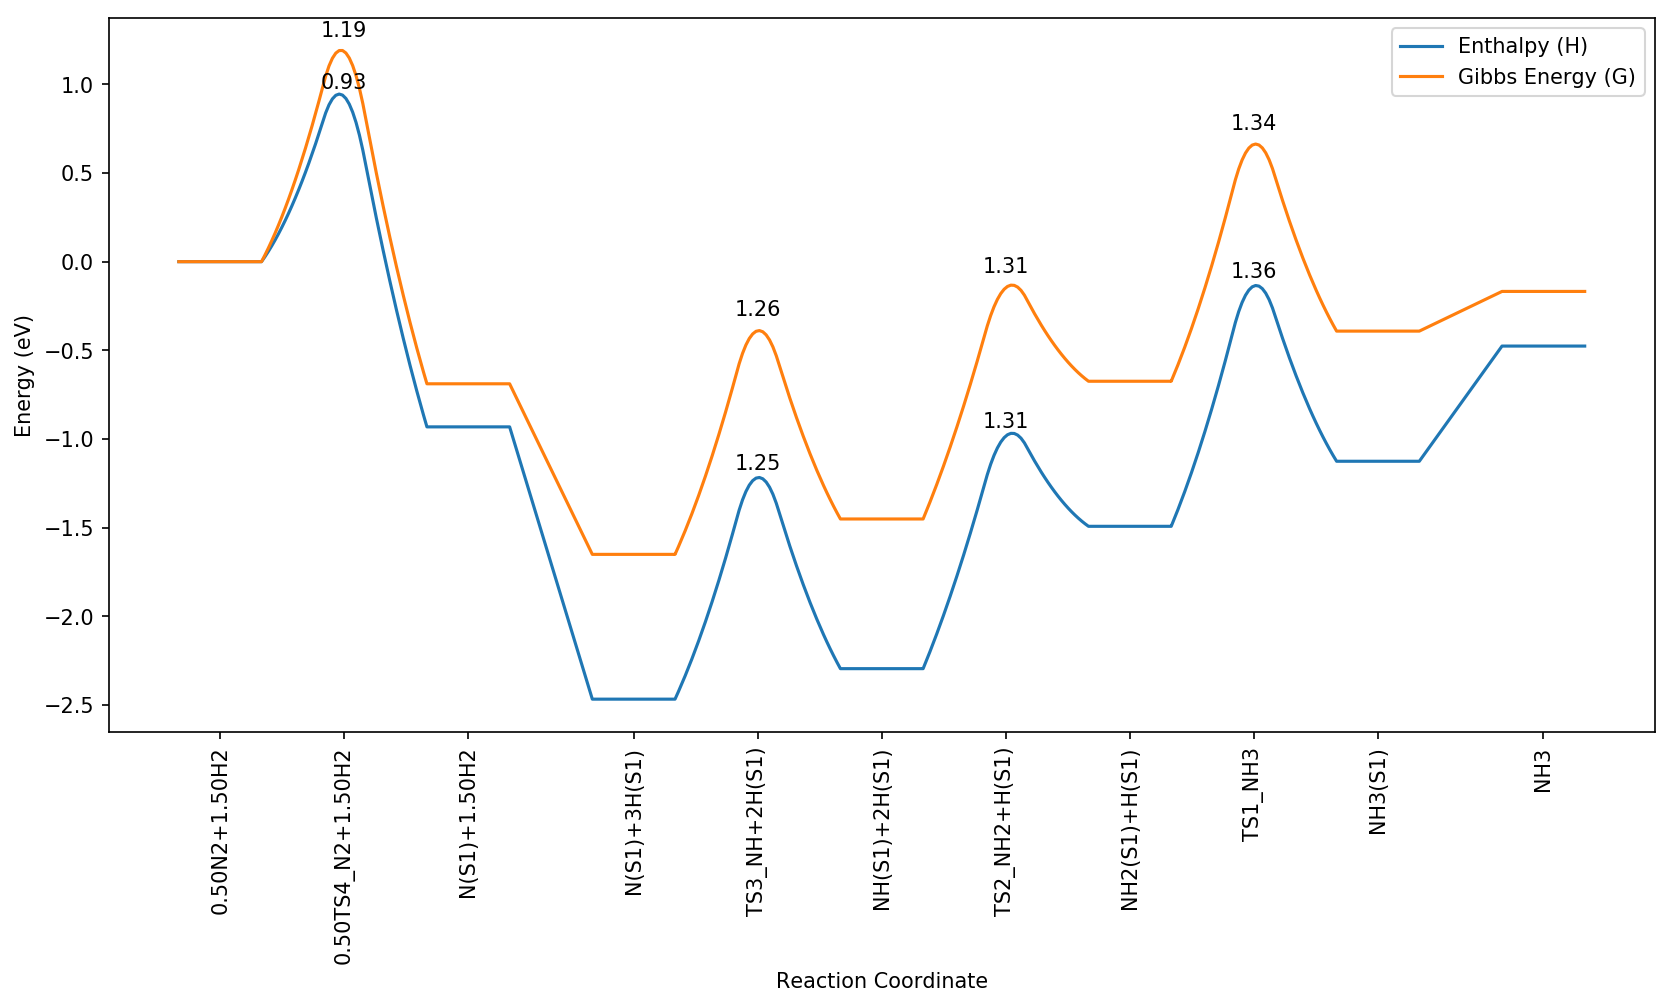

In [9]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
from pmutt import pmutt_list_to_dict
from pmutt.reaction import Reaction, Reactions
from pmutt.io.thermdat import read_thermdat

# Find the location of Jupyter notebook
# Note that normally Python scripts have a __file__ variable but Jupyter notebook doesn't.
# Using pathlib can overcome this limiation
notebook_folder = Path().resolve()

'''Read the thermdat file and convert it to a dictionary'''
NH3_species_list = read_thermdat(os.path.join(notebook_folder, 'thermdat_NH3'))
NH3_species = pmutt_list_to_dict(NH3_species_list)

'''Initialize the reaction'''
rxns = Reactions(reactions=[
    Reaction.from_string('0.5N2 + 1.5H2 = 0.5TS4_N2 + 1.5H2 = N(S1) + 1.5H2', 
                         NH3_species),
    Reaction.from_string('N(S1) + 1.5H2 = N(S1) + 3H(S1)', NH3_species),
    Reaction.from_string('N(S1) + 3H(S1) = TS3_NH + 2H(S1) = NH(S1) + 2H(S1)', 
                         NH3_species),
    Reaction.from_string('NH(S1) + 2H(S1) = TS2_NH2 + H(S1) = NH2(S1) + H(S1)',
                         NH3_species),
    Reaction.from_string('NH2(S1) + H(S1) = TS1_NH3 = NH3(S1)', NH3_species),
    Reaction.from_string('NH3(S1) = NH3', NH3_species)])

'''Plot the reaction coordinate diagram'''
# Enthalpy coordinate diagram
fig1, ax1 = rxns.plot_coordinate_diagram(method_name='get_H', units='eV',
                                         T=300.)
# Gibbs energy coordinate diagram on the same plot
fig1, ax1 = rxns.plot_coordinate_diagram(method_name='get_G', units='eV',
                                         T=300., figure=fig1, axes=ax1)

'''Adjust plot settings'''
ax1.legend(['Enthalpy (H)', 'Gibbs Energy (G)'])
ax1.set_ylabel('Energy (eV)')
fig1.set_size_inches(12, 10)
fig1.dpi = 150
plt.show()